In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
SEED =1234
EMB_SIZE =300
SEQUENCE_LEN = 128
CLASS_NUM = 3

In [ ]:
#@title
!pip install fasttext
!pip install hazm
!pip install --upgrade gensim

     |████████████████████████████████| 68 kB 3.0 MB/s 
  Using cached pybind11-2.7.1-py2.py3-none-any.whl (200 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3095304 sha256=154f87bc6ab658bcd02a1dca30a452ccd521ce0655f48b8af96ade2d11a18ca5
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext
     |████████████████████████████████| 316 kB 5.2 MB/s 
     |████████████████████████████████| 1.4 MB 9.8 MB/s 
     |████████████████████████████████| 233 kB 36.2 MB/s 
  Created wheel for nltk: filename=nltk-3.3-py3-none-any.whl size=1394489 sha256=1d1cb19529053dfd9e6e9da56c2cf038c84a846044cca55ca0b9a472ac513310
  Stored in directory: /root/.cache/pip/wheels/9b/fd/0c/d92302c876e5de87ebd7fc0979d82edb93e2d8d768bf71fac4
  Created wheel for libwapiti: filename=libwapiti-0.2.1-cp37-cp37m-linux_x86_64.whl size=153511 sha256=bd70c7dcba430874757893bce04613959b296ca54b76f9e4747f98

In [ ]:
import fasttext 
import hazm
import pandas as pd
import pickle
import numpy as np
import gensim


import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Embedding, Dropout
from tensorflow.keras.layers import  LSTM, Bidirectional,GRU

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import categorical_accuracy ,AUC
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.utils import plot_model


import matplotlib.pyplot as plot

/usr/local/lib/python3.7/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [ ]:
#import gzip
#import shutil
#with gzip.open('/content/drive/MyDrive/Karimi/cc.fa.300.bin.gz', 'rb') as f_in:
#    with open('/content/drive/MyDrive/Karimi/cc.fa.300.bin', 'wb') as f_out:
#        shutil.copyfileobj(f_in, f_out)

In [ ]:
FT_EMBEDDING_PATH = '/content/drive/MyDrive/Karimi/cc.fa.300.bin'

In [ ]:
ft_embedding = fasttext.load_model('/content/drive/MyDrive/Karimi/cc.fa.300.bin')
len(ft_embedding.words)

2000000

In [ ]:
def get_tokenized_data(data_name):
    x , y= load_data(data_name)
    tokenized_x =  [hazm.word_tokenize(sent) for sent in x]
    return tokenized_x,y

In [ ]:
def load_data_test(data_name):
    data_test = pd.read_csv('/content/drive/MyDrive/Karimi/test.csv', index_col=None,  encoding="utf-8")
    x , y= np.asarray(data_test['review']), np.asarray(data_test['sentiment'])
    return x,y

def load_data_train(data_name):
    data_train = pd.read_csv('/content/drive/MyDrive/Karimi/train.csv', index_col=None,  encoding="utf-8")
    x , y= np.asarray(data_train['review']), np.asarray(data_train['sentiment'])
    return x,y

def load_data_valid(data_name):
    data_valid = pd.read_csv('/content/drive/MyDrive/Karimi/valid.csv', index_col=None,  encoding="utf-8")
    x , y= np.asarray(data_valid['review']), np.asarray(data_valid['sentiment'])
    return x,y



x_test , y_test= load_data_test('test')
x_train , y_train= load_data_train('train')
x_val , y_val= load_data_valid('valid')
len(x_test), len(x_train), len(x_val)

(2249, 18214, 2024)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

In [ ]:
# Save tokenizer
with open("/content/drive/MyDrive/Karimi/tokenizer", 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
from gensim.models import FastText
from gensim.test.utils import common_texts

def train_fasttext_emb(corpus):
    sentences = [[word for word in hazm.word_tokenize(text)] for text in corpus]
    emb_model = FastText(sentences, vector_size=100, min_count=1)
    emb_model.build_vocab(sentences)
    emb_model.train(sentences, total_examples=len(corpus), epochs=10)  
    emb_model.save(FT_EMBEDDING_PATH)
    return emb_model

# Train the embedding
emb_model = train_fasttext_emb(x_train)

# load the pretrained model
#emb_model = FastText.load(EMBEDDING_PATH)

print(emb_model.wv.most_similar('عالی'))

[('عالیع', 0.9423313140869141), ('عالیعع', 0.9326892495155334), ('عالیلک', 0.9207160472869873), ('عالیی', 0.9135940670967102), ('ژنعالی', 0.9134215116500854), ('وعالی', 0.8992059826850891), ('عالیولی', 0.8949706554412842), ('عالیش', 0.8921489715576172), ('عالیشاهو', 0.8896855115890503), ('عالیمبا', 0.883955180644989)]


In [ ]:
def get_emb_matrix(emb_model_):
    embedding_matrix = np.random.random((len(tokenizer.word_index)+1, emb_model_.vector_size))
    pas = 0
    for word,i in tokenizer.word_index.items():
        try:
            embedding_matrix[i] = emb_model_.wv[word]
        except:
            print(word)
            pas+=1
    return embedding_matrix

embedding_matrix = get_emb_matrix(emb_model)

In [ ]:
def prepare_data(x , y ):
    sequence_docs = tokenizer.texts_to_sequences(x)
    pad_sequence_docs = pad_sequences(sequence_docs, maxlen=SEQUENCE_LEN, padding='post')
    categorical_y = to_categorical(y, CLASS_NUM)
    return pad_sequence_docs, categorical_y


train_pad_sequence, train_categorical_y = prepare_data(x_train , y_train)
val_pad_sequence, val_categorical_y = prepare_data(x_val , y_val)
test_pad_sequence, test_categorical_y = prepare_data(x_test , y_test)

In [ ]:
#from sklearn.utils import class_weight
import sklearn
import numpy as np
class_w = sklearn.utils.class_weight.compute_class_weight('balanced', np.unique(y_train) , y_train)
class_w_dic = {}
for i in range(len(class_w)):
    class_w_dic[i] = class_w[i]
    
class_w_dic

{0: 0.6821722846441948, 1: 2.3781172476824652, 2: 0.8979933934822265}

In [ ]:
class_w_dic={0:70, 1:20, 2:10}

In [ ]:
temp_model = Sequential()
temp_model.add(Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], weights=[embedding_matrix], trainable=False))
temp_model.add(Bidirectional(GRU(100, return_sequences=True, name='lstm_layer')))
temp_model.add(Dropout(0.2))
temp_model.add(Dense(50, activation="relu", kernel_regularizer='l2'))
temp_model.add(Bidirectional(GRU(50)))
temp_model.add(Dropout(0.1))
temp_model.add(Dense(3, activation='softmax', kernel_regularizer='l2'))

In [ ]:
#Config
METRICS = [
    categorical_accuracy,
    tf.keras.metrics.AUC(name='auc'),
    #tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]
opt = tf.keras.optimizers.Adam(learning_rate=0.005)
temp_model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=[METRICS])

temp_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         16513700  
_________________________________________________________________
bidirectional (Bidirectional (None, None, 200)         121200    
_________________________________________________________________
dropout (Dropout)            (None, None, 200)         0         
_________________________________________________________________
dense (Dense)                (None, None, 50)          10050     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100)               30600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3

In [ ]:
batch_size = 32
epochs = 20
history = temp_model.fit(train_pad_sequence, train_categorical_y,
                         batch_size=batch_size, epochs=epochs, 
                         class_weight=class_w_dic,
                         validation_data=(val_pad_sequence, val_categorical_y), shuffle=True)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/20
570/570 [==============================] - 186s 311ms/step - loss: 9.6244 - categorical_accuracy: 0.7978 - auc: 0.9415 - val_loss: 0.9495 - val_categorical_accuracy: 0.8528 - val_auc: 0.9673
Epoch 2/20
570/570 [==============================] - 171s 300ms/step - loss: 7.0952 - categorical_accuracy: 0.8574 - auc: 0.9684 - val_loss: 0.9987 - val_categorical_accuracy: 0.8330 - val_auc: 0.9587
Epoch 3/20
570/570 [==============================] - 170s 299ms/step - loss: 6.3956 - categorical_accuracy: 0.8752 - auc: 0.9748 - val_loss: 0.9274 - val_categorical_accuracy: 0.8666 - val_auc: 0.9735
Epoch 4/20
570/570 [==============================] - 170s 297ms/step - loss: 6.1545 - categorical_accuracy: 0.8783 - auc: 0.9771 - val_loss: 1.0950 - val_categorical_accuracy: 0.8177 - val_auc: 0.9541
Epoch 5/20
570/570 [==============================] - 

<function matplotlib.pyplot.show>

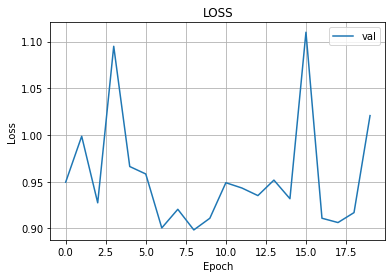

In [ ]:
import matplotlib.pyplot as plt
#plt.plot(history.history['loss'] , label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("LOSS")
plt.show

In [ ]:
#FIX EMB 100
batch_size = 256
epochs = 13
history = temp_model.fit(train_pad_sequence, train_categorical_y,
                         batch_size=batch_size, epochs=epochs, 
                         class_weight=class_w_dic,
                         validation_data=(val_pad_sequence, val_categorical_y) , 
                         shuffle=True)

In [ ]:
print("Evaluate on test data")
results = temp_model.evaluate(test_pad_sequence, test_categorical_y, batch_size=batch_size)
print("test loss:{loss}, test acc:{acc}, test auc: {auc}".format( loss = results[0],acc = results[1] ,auc=results[2] ))

In [ ]:
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = temp_model.predict(test_pad_sequence[:3])
print("predictions shape:", predictions.shape)
preds = np.argmax(predictions, axis = 1)
x_test[:3] , preds

In [ ]:
import os

if not os.path.exists('/content/drive/MyDrive/Karimi/models'):
    os.makedirs('/content/drive/MyDrive/Karimi/models')
temp_model.save('/content/drive/MyDrive/Karimi/models/model.h5'.format(emb_size=EMB_SIZE),
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None,
)

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/Karimi/models/model.h5'.format(emb_size=EMB_SIZE))

In [ ]:
print("Evaluate on test data")
results = model.evaluate(test_pad_sequence, test_categorical_y, batch_size=batch_size)
print("test loss, test acc:", results)
predictions = model.predict(test_pad_sequence)